## Data Roundup

Rerun the analysis done in [Linear SVC 12/20/2018](2018-12-20_LinearSVC.ipynb) and extract data needed for Derek's paper:

For cross validation (need both mean and standard deviation) and holdout:
* Accuracy
* Sensitivity
* Specificity
* PPV
* NPV
* Recall
* Precision
* Area Under the Curve
* Support

Also need ROC curve as a list of numbers.

Variable contribution (importance) to models (mean and standard deviation).

## Imports and Function Definitions

In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support, roc_curve, make_scorer, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold, train_test_split, LeaveOneOut, GridSearchCV, cross_validate
from sklearn.svm import SVC

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

def grid_search_optimization(model, tuned_parameters, X, y, Xh, yh, cv=5, scoring='accuracy', verbose=False):
    print("# Tuning hyper-parameters for %s" %scoring)
    print()

    clf = GridSearchCV(model, tuned_parameters, cv=cv, n_jobs = -1, scoring=scoring, verbose=1)
    clf.fit(X, y)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    if verbose:
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

    print("Detailed classification report (holdout):")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = yh, clf.predict(Xh)
    print(classification_report(y_true, y_pred))
    print()
    
    get_metrics(clf.best_estimator_, Xh, yh)
    
    return clf

def group_classes(data, grouping):
        classes_to_keep = grouping.keys()
        data_to_keep = data.loc[data['GroupID'].isin(classes_to_keep)]
        classes_to_change = {k:grouping[k] for k in classes_to_keep if k!= grouping[k]}
        return data_to_keep.replace(classes_to_change)
    
def plot_coefficients(classifier, feature_names, top_features=20):
     coef = classifier.coef_.ravel()
     top_positive_coefficients = np.argsort(coef)[-top_features:]
     top_negative_coefficients = np.argsort(coef)[:top_features]
     top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
     # create plot
     plt.figure(figsize=(15, 5))
     colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
     plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
     feature_names = np.array(feature_names)
     plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
     plt.show()
        
def print_feature_importance(feature_names, coefs):
    assert len(feature_names) == len(coefs), "Arrays have difference lengths. Something went wrong"
    for feature, coef in zip(feature_names, coefs):
        print("%s\t%s" %(feature, coef))
        
# AKA True Negative Rate
def specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[0,0] / cm[0,:].sum()

def negative_predictive_value(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[0,0] / cm[:,0].sum()

def plot_roc(model, X_test, Y_test):
    y_true, y_pred = Y_test, model.predict(X_test)
    print(classification_report(y_true, y_pred))

    y_pred_prob = model.predict_proba(X_test)[:,1]

    fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)

    plt.plot([0,1],[0,1], 'k--')
    plt.plot(fpr, tpr, label='Linear SVC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Linear SVC ROC Curve')
    plt.show()
    
    for a,b in zip(fpr, tpr):
        print(a,b)
    
def get_metrics(model, X, y):
    for metric in _scoring_list:
        score = _scoring_list[metric](model, X, y)
        print("%s\t%s" %(metric, score))

## Define classifier, pipeline and constants

In [18]:
param_grid = {
    "classifier__C": np.logspace(-5, 10, 20),
#     "PCA__n_components": range(1,113,10),
#     "fss__k": range(1,115,3),
},

clf = Pipeline([
#     ('Norm', Normalizer()),\n",
#     ("Oversample", RandomOverSampler()),
#     ('PCA', PCA()),
    ('Scaler', StandardScaler()),
#     ('fss',SelectKBest()),
    ('classifier', SVC(kernel='linear', class_weight='balanced', probability=True))
])

_cv=5
_test_size=0.20
_scoring_list={
    'recall':make_scorer(recall_score),
    'precision':make_scorer(precision_score),
    'auc':make_scorer(roc_auc_score),
    'specificity':make_scorer(specificity),
    'npv':make_scorer(negative_predictive_value),
    'accuracy':make_scorer(accuracy_score)
}
_scoring='f1_micro'
_data = pd.read_excel('training_data_1004.xlsx')
_random_seed = 55

## 1. Control vs. PD/MSA/PSP

In [19]:
# Get the data
data1 = group_classes(_data, {0:0, 1:1, 2:1, 3:1})

y1 = data1['GroupID']
X1 = data1.drop(['GroupID'], axis=1)

X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X1, y1, test_size=_test_size, random_state=_random_seed)

best1 = grid_search_optimization(clf, param_grid, X_train1, Y_train1, X_test1, Y_test1, cv=_cv, scoring=_scoring)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.3s finished
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, fl

Best parameters set found on development set:

{'classifier__C': 0.08858667904100832}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.87      0.96      0.92        56
           1       0.99      0.94      0.96       145

   micro avg       0.95      0.95      0.95       201
   macro avg       0.93      0.95      0.94       201
weighted avg       0.95      0.95      0.95       201


recall	0.9448275862068966
precision	0.9856115107913669
auc	0.9545566502463053
specificity	0.9642857142857143
npv	0.8709677419354839
accuracy	0.9502487562189055


C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all conver

In [20]:
scores = cross_validate(best1.best_estimator_, X_train1, Y_train1, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64

fit_time	0.11118130683898926	0.006515782825412354
score_time	0.031359624862670896	0.00438569587063488
test_recall	0.9397730621868552	0.015356924761121438
train_recall	0.9565387467556545	0.0053524188607059
test_precision	0.982027673606621	0.009916403052994663
train_precision	0.9910831085115083	0.002445695856824504
test_auc	0.9473612785681752	0.017712095882282262
train_auc	0.9670080263328199	0.004880145261659462
test_specificity	0.954949494949495	0.02490139722417094
train_specificity	0.9774773059099854	0.006154500331133872
test_npv	0.8589531131601577	0.03415686159650538
train_npv	0.8958986287263165	0.011757601312760272
test_accuracy	0.943950904838586	0.015808461165530405
train_accuracy	0.9623289966118491	0.004860392732144633


C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all conver

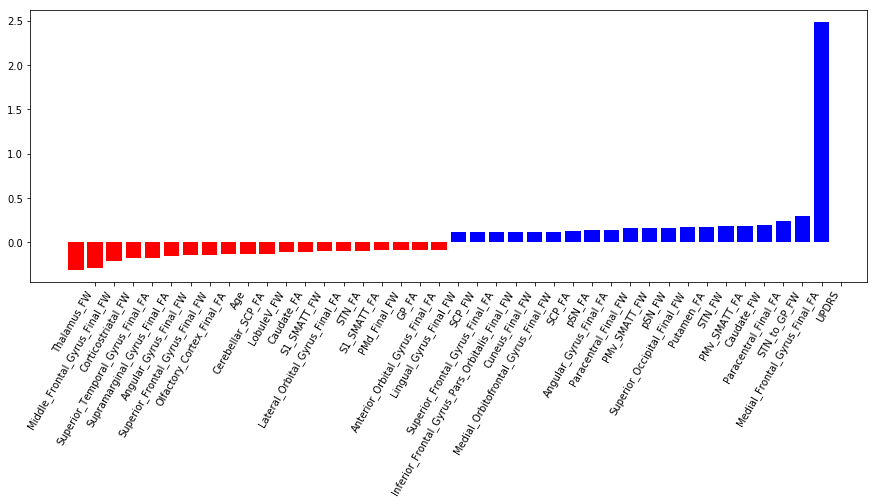

Age	-0.13850691523789724
Sex	-0.039918453228996405
UPDRS	2.4820938668524337
aSN_FA	-0.07226076021950528
Caudate_FA	-0.11125568470835502
CC2_FA	0.09207292465559681
GP_FA	-0.09224355565794258
LobuleVI_FA	0.08216315790793635
LobuleV_FA	-0.05255547641685045
MCP_FA	0.014637390263164463
pSN_FA	0.12421947071361565
Putamen_FA	0.16646040271226245
SCP_FA	0.1207395247770571
STN_FA	-0.09613048186452253
Thalamus_FA	0.0810679103878541
Vermis_FA	0.046654953870612595
RN_FA	0.021360787936092692
PPN_FA	0.009097432279094639
Dentate_FA	-0.05433978805943871
CC1_FA	-0.06807381360223151
aSN_FW	-0.026027125583265972
Caudate_FW	0.18415156899043328
CC2_FW	0.010783575297456586
GP_FW	-0.053308524807798845
LobuleVI_FW	0.06557935270773442
LobuleV_FW	-0.1280610054350146
MCP_FW	-0.0353753859049983
pSN_FW	0.1644477839968238
Putamen_FW	-0.08172202639585796
SCP_FW	0.11529980259925078
STN_FW	0.17217246863423544
Thalamus_FW	-0.308983830125439
Vermis_FW	-0.03492289933121627
RN_FW	-0.05525282233306149
PPN_FW	0.0351473078023

In [21]:
model = best1.best_estimator_.named_steps['classifier']
feature_names = data1.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

              precision    recall  f1-score   support

           0       0.87      0.96      0.92        56
           1       0.99      0.94      0.96       145

   micro avg       0.95      0.95      0.95       201
   macro avg       0.93      0.95      0.94       201
weighted avg       0.95      0.95      0.95       201



C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:405: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


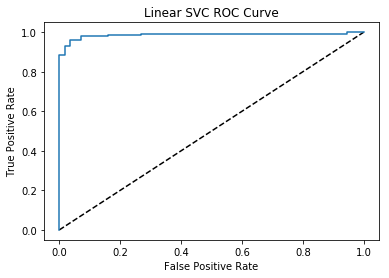

0.0 0.0
0.0 0.05517241379310345
0.0 0.8827586206896552
0.017857142857142856 0.8827586206896552
0.017857142857142856 0.9310344827586207
0.03571428571428571 0.9310344827586207
0.03571428571428571 0.9586206896551724
0.07142857142857142 0.9586206896551724
0.07142857142857142 0.9793103448275862
0.16071428571428573 0.9793103448275862
0.16071428571428573 0.9862068965517241
0.26785714285714285 0.9862068965517241
0.26785714285714285 0.993103448275862
0.9464285714285714 0.993103448275862
0.9464285714285714 1.0
1.0 1.0


In [22]:
plot_roc(best1.best_estimator_, X_test1, Y_test1)

## 2. PD vs MSA/PSP

In [23]:
# Get the data
data2 = group_classes(_data, {1:0, 2:1, 3:1})

y2 = data2['GroupID']
X2 = data2.drop(['GroupID'], axis=1)

X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, y2, test_size=_test_size, random_state=_random_seed)

best2 = grid_search_optimization(clf, param_grid, X_train2, Y_train2, X_test2, Y_test2, cv=_cv, scoring=_scoring)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.1s


Best parameters set found on development set:

{'classifier__C': 0.01438449888287663}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.97      0.92      0.95       117
           1       0.74      0.90      0.81        29

   micro avg       0.92      0.92      0.92       146
   macro avg       0.86      0.91      0.88       146
weighted avg       0.93      0.92      0.92       146


recall	0.896551724137931
precision	0.7428571428571429
auc	0.9098143236074271
specificity	0.9230769230769231
npv	0.972972972972973
accuracy	0.9178082191780822


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.3s finished
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imble

In [24]:
scores = cross_validate(best2.best_estimator_, X_train2, Y_train2, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64

fit_time	0.05707607269287109	0.005594841842513116
score_time	0.026754093170166016	0.004009361951655961
test_recall	0.8087087087087086	0.06413784540162161
train_recall	0.8838878016960209	0.022039927768590904
test_precision	0.8140351714848618	0.06763492214306482
train_precision	0.8925390773081927	0.008371905818561095
test_auc	0.8602720758733418	0.03541300336519203
train_auc	0.9173858388278926	0.010065640503135513
test_specificity	0.9118354430379748	0.03806495073270117
train_specificity	0.9508838759597642	0.004685800590078375
test_npv	0.9127735951389464	0.028123647975249046
train_npv	0.946825324242138	0.009453396646233769
test_accuracy	0.8794070913261318	0.03121160278157877
train_accuracy	0.9297420500019621	0.00603451735678944


C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


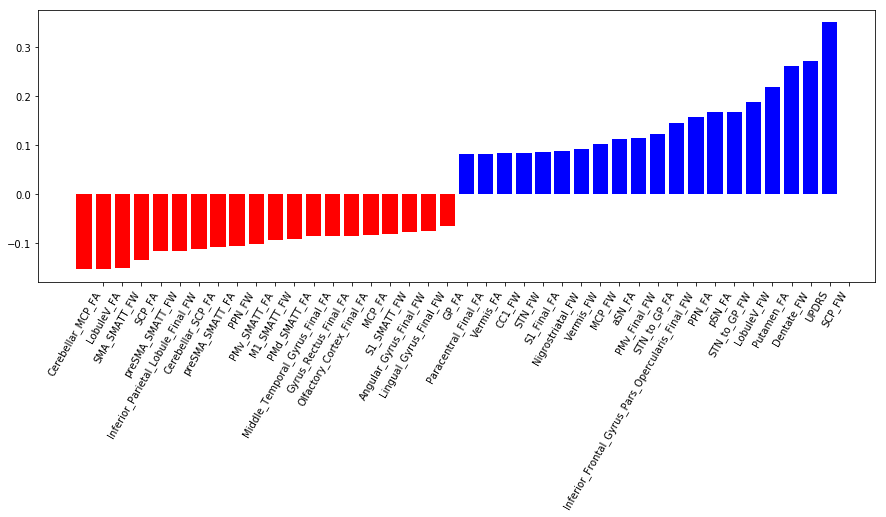

Age	-0.0014699690772996645
Sex	0.0
UPDRS	0.2710061194785825
aSN_FA	0.11195923426972967
Caudate_FA	-0.0017141302855592693
CC2_FA	0.04477776186972805
GP_FA	-0.06534800070093405
LobuleVI_FA	0.06689500218676593
LobuleV_FA	-0.1521155070648222
MCP_FA	-0.08336146532665191
pSN_FA	0.16824317141995604
Putamen_FA	0.2185390399316231
SCP_FA	-0.1347459290170494
STN_FA	0.06415367242731455
Thalamus_FA	0.0027639218800325376
Vermis_FA	0.08287702722056373
RN_FA	-0.04241497403519313
PPN_FA	0.15771198796872798
Dentate_FA	0.02475956569222093
CC1_FA	-0.051485753103486756
aSN_FW	-0.004161233314598634
Caudate_FW	0.06295959445061683
CC2_FW	-0.019902852984362614
GP_FW	0.020339403401393813
LobuleVI_FW	-0.03816104244574298
LobuleV_FW	0.18810631928105995
MCP_FW	0.1031525416397629
pSN_FW	0.03596750025465352
Putamen_FW	-0.004146047437822175
SCP_FW	0.3508874768365768
STN_FW	0.08453017429930912
Thalamus_FW	0.07110385871377126
Vermis_FW	0.09193202029081594
RN_FW	0.01620589529163191
PPN_FW	-0.10597877560012071
Dentate_FW

In [25]:
model = best2.best_estimator_.named_steps['classifier']
feature_names = data2.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

              precision    recall  f1-score   support

           0       0.97      0.92      0.95       117
           1       0.74      0.90      0.81        29

   micro avg       0.92      0.92      0.92       146
   macro avg       0.86      0.91      0.88       146
weighted avg       0.93      0.92      0.92       146



C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:405: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


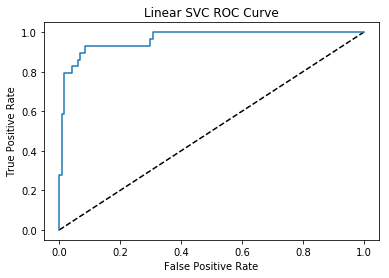

0.0 0.0
0.0 0.034482758620689655
0.0 0.27586206896551724
0.008547008547008548 0.27586206896551724
0.008547008547008548 0.5862068965517241
0.017094017094017096 0.5862068965517241
0.017094017094017096 0.7931034482758621
0.042735042735042736 0.7931034482758621
0.042735042735042736 0.8275862068965517
0.05982905982905983 0.8275862068965517
0.05982905982905983 0.8620689655172413
0.06837606837606838 0.8620689655172413
0.06837606837606838 0.896551724137931
0.08547008547008547 0.896551724137931
0.08547008547008547 0.9310344827586207
0.29914529914529914 0.9310344827586207
0.29914529914529914 0.9655172413793104
0.3076923076923077 0.9655172413793104
0.3076923076923077 1.0
1.0 1.0


In [26]:
plot_roc(best2.best_estimator_, X_test2, Y_test2)

## 3. MSA vs PD/PSP

In [27]:
# Get the data
data3 = group_classes(_data, {1:0, 3:0, 2:1})

y3 = data3['GroupID']
X3 = data3.drop(['GroupID'], axis=1)

X_train3, X_test3, Y_train3, Y_test3 = train_test_split(X3, y3, test_size=_test_size, random_state=_random_seed)

best3 = grid_search_optimization(clf, param_grid, X_train3, Y_train3, X_test3, Y_test3, cv=_cv, scoring=_scoring)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.2s finished
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\jtbri_000\Anaconda3\lib\s

Best parameters set found on development set:

{'classifier__C': 0.002335721469090121}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.98      0.91      0.94       132
           1       0.50      0.86      0.63        14

   micro avg       0.90      0.90      0.90       146
   macro avg       0.74      0.88      0.79       146
weighted avg       0.94      0.90      0.91       146


recall	0.8571428571428571
precision	0.5
auc	0.8831168831168831
specificity	0.9090909090909091
npv	0.9836065573770492
accuracy	0.9041095890410958


C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [28]:
scores = cross_validate(best3.best_estimator_, X_train3, Y_train3, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64

fit_time	0.09613213539123536	0.004254701540216771
score_time	0.03375253677368164	0.000743008841140429
test_recall	0.7120879120879121	0.08691745025619864
train_recall	0.8407792207792207	0.03767218859078625
test_precision	0.5526931721305123	0.11706904104166803
train_precision	0.589030509929526	0.03546327221824591
test_auc	0.8140203504852277	0.050122246949178405
train_auc	0.880273233765611	0.014508510930540756
test_specificity	0.9159527888825434	0.03608770627233865
train_specificity	0.9197672467520015	0.014772707955362925
test_npv	0.9590982027264511	0.013161749106342574
train_npv	0.9772171747025803	0.005184695796060829
test_accuracy	0.8914641397250094	0.03513489205597704
train_accuracy	0.9103483832528102	0.010315677942274195


C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all conver

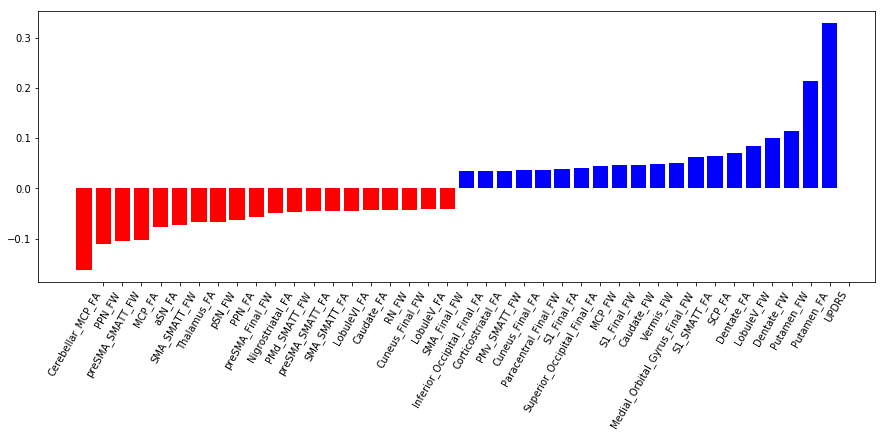

Age	0.0030144066160749383
Sex	0.0
UPDRS	0.32963475328650804
aSN_FA	-0.07649687881188688
Caudate_FA	-0.04379951763031917
CC2_FA	0.027678023946529025
GP_FA	0.02997286130874614
LobuleVI_FA	-0.044162575169278434
LobuleV_FA	-0.04117990102629799
MCP_FA	-0.10240888849947646
pSN_FA	0.009664218485611324
Putamen_FA	0.21470481652673093
SCP_FA	0.06441274742144854
STN_FA	-0.019687881221995836
Thalamus_FA	-0.06774214225424684
Vermis_FA	-0.0027332283825996367
RN_FA	0.02051364618717083
PPN_FA	-0.0624667463756406
Dentate_FA	0.07027775363515086
CC1_FA	-0.012669570689895958
aSN_FW	-0.006444257839248435
Caudate_FW	0.046322788705026166
CC2_FW	-0.028137767898861188
GP_FW	-0.002784651161278771
LobuleVI_FW	-0.007373898825115997
LobuleV_FW	0.0848432753828643
MCP_FW	0.04373510599474961
pSN_FW	-0.06753413882608757
Putamen_FW	0.11439441709561692
SCP_FW	0.02408625721845135
STN_FW	-0.01713701959692153
Thalamus_FW	0.01549680633694997
Vermis_FW	0.04932851014767705
RN_FW	-0.04314142439444335
PPN_FW	-0.1099425778187224

In [29]:
model = best3.best_estimator_.named_steps['classifier']
feature_names = data3.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

              precision    recall  f1-score   support

           0       0.98      0.91      0.94       132
           1       0.50      0.86      0.63        14

   micro avg       0.90      0.90      0.90       146
   macro avg       0.74      0.88      0.79       146
weighted avg       0.94      0.90      0.91       146



C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:405: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


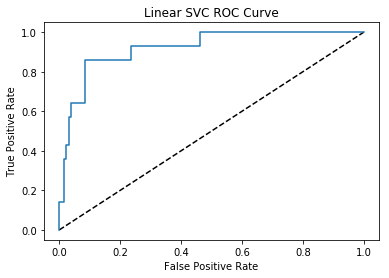

0.0 0.0
0.0 0.07142857142857142
0.0 0.14285714285714285
0.015151515151515152 0.14285714285714285
0.015151515151515152 0.35714285714285715
0.022727272727272728 0.35714285714285715
0.022727272727272728 0.42857142857142855
0.030303030303030304 0.42857142857142855
0.030303030303030304 0.5714285714285714
0.03787878787878788 0.5714285714285714
0.03787878787878788 0.6428571428571429
0.08333333333333333 0.6428571428571429
0.08333333333333333 0.8571428571428571
0.23484848484848486 0.8571428571428571
0.23484848484848486 0.9285714285714286
0.4621212121212121 0.9285714285714286
0.4621212121212121 1.0
1.0 1.0


In [30]:
plot_roc(best3.best_estimator_, X_test3, Y_test3)

## 4. PSP vs PD/MSA

In [31]:
# Get the data
data4 = group_classes(_data, {1:0, 2:0, 3:1})

y4 = data4['GroupID']
X4 = data4.drop(['GroupID'], axis=1)

X_train4, X_test4, Y_train4, Y_test4 = train_test_split(X4, y4, test_size=_test_size, random_state=_random_seed)

best4 = grid_search_optimization(clf, param_grid, X_train4, Y_train4, X_test4, Y_test4, cv=_cv, scoring=_scoring)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.2s


Best parameters set found on development set:

{'classifier__C': 0.01438449888287663}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       131
           1       0.61      0.73      0.67        15

   micro avg       0.92      0.92      0.92       146
   macro avg       0.79      0.84      0.81       146
weighted avg       0.93      0.92      0.93       146


recall	0.7333333333333333
precision	0.6111111111111112
auc	0.8399491094147583
specificity	0.9465648854961832
npv	0.96875
accuracy	0.9246575342465754


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.8s finished
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by Standa

In [32]:
scores = cross_validate(best4.best_estimator_, X_train4, Y_train4, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64

fit_time	0.05206003189086914	0.007531386375284687
score_time	0.023574399948120116	0.00482232702238521
test_recall	0.833201581027668	0.03310733848438246
train_recall	0.9123029144768274	0.009595116825413358
test_precision	0.8613955609607784	0.0628801542885878
train_precision	0.9125363883428399	0.013944986940419393
test_auc	0.8994079284685356	0.01629174877360521
train_auc	0.9454225518217111	0.005095700507359393
test_specificity	0.965614275909403	0.01852891235655715
train_specificity	0.9785421891665946	0.003784369885185369
test_npv	0.9595749472457757	0.007529364307495665
train_npv	0.9785474862782271	0.002336955310314861
test_accuracy	0.9396388984994684	0.01446176789984266
train_accuracy	0.965521820100888	0.003559161332440288


C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


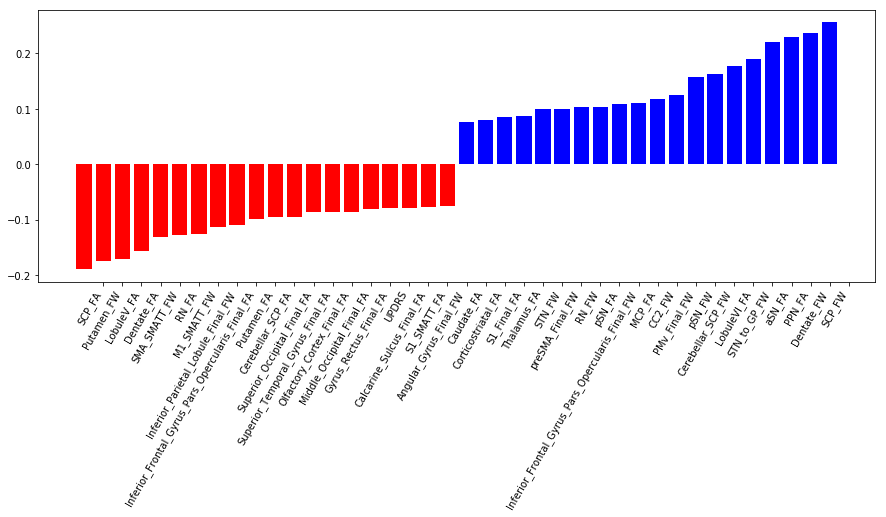

Age	0.05162290794988379
Sex	0.0
UPDRS	-0.07979702037650302
aSN_FA	0.22049301633587245
Caudate_FA	0.07648454800265768
CC2_FA	0.024072845449339093
GP_FA	-0.0275798661452689
LobuleVI_FA	0.1779683376833004
LobuleV_FA	-0.1714211481988299
MCP_FA	0.11077919557338017
pSN_FA	0.10372770742526798
Putamen_FA	-0.0985866962957225
SCP_FA	-0.18966831401095857
STN_FA	0.007165930773399523
Thalamus_FA	0.0861590428656062
Vermis_FA	0.06541666608842761
RN_FA	-0.12774349952148703
PPN_FA	0.22963580707881784
Dentate_FA	-0.1560626566203098
CC1_FA	-0.06443796873191772
aSN_FW	-0.0387797122267644
Caudate_FW	-0.018678217219590315
CC2_FW	0.11705423824714495
GP_FW	0.00968714229757428
LobuleVI_FW	-0.023029009876714985
LobuleV_FW	0.05189695321905531
MCP_FW	0.05164180586644176
pSN_FW	0.1576929231977592
Putamen_FW	-0.17443442497643352
SCP_FW	0.25642817903038606
STN_FW	0.09898353099263708
Thalamus_FW	0.0732988217315789
Vermis_FW	0.05496144286028695
RN_FW	0.10328575863767048
PPN_FW	0.025265768305174914
Dentate_FW	0.2370433

In [33]:
model = best4.best_estimator_.named_steps['classifier']
feature_names = data4.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       131
           1       0.61      0.73      0.67        15

   micro avg       0.92      0.92      0.92       146
   macro avg       0.79      0.84      0.81       146
weighted avg       0.93      0.92      0.93       146



C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:405: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


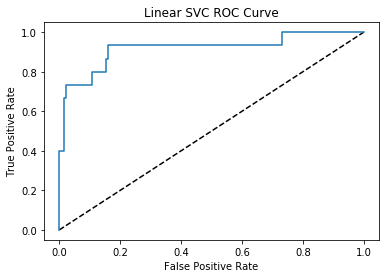

0.0 0.0
0.0 0.06666666666666667
0.0 0.4
0.015267175572519083 0.4
0.015267175572519083 0.6666666666666666
0.022900763358778626 0.6666666666666666
0.022900763358778626 0.7333333333333333
0.10687022900763359 0.7333333333333333
0.10687022900763359 0.8
0.15267175572519084 0.8
0.15267175572519084 0.8666666666666667
0.16030534351145037 0.8666666666666667
0.16030534351145037 0.9333333333333333
0.732824427480916 0.9333333333333333
0.732824427480916 1.0
1.0 1.0


In [34]:
plot_roc(best4.best_estimator_, X_test4, Y_test4)